In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shashidhargadepalli","key":"daa7ceb09fdf86b2cda1ad4b529aa0cf"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
100% 1.62G/1.62G [01:24<00:00, 23.4MB/s]
100% 1.62G/1.62G [01:24<00:00, 20.7MB/s]


In [4]:
!unzip ocular-disease-recognition-odir5k.zip -d odir_data

Streaming output truncated to the last 5000 lines.
  inflating: odir_data/preprocessed_images/2179_left.jpg  
  inflating: odir_data/preprocessed_images/2179_right.jpg  
  inflating: odir_data/preprocessed_images/217_left.jpg  
  inflating: odir_data/preprocessed_images/217_right.jpg  
  inflating: odir_data/preprocessed_images/2180_left.jpg  
  inflating: odir_data/preprocessed_images/2180_right.jpg  
  inflating: odir_data/preprocessed_images/2181_left.jpg  
  inflating: odir_data/preprocessed_images/2181_right.jpg  
  inflating: odir_data/preprocessed_images/2182_left.jpg  
  inflating: odir_data/preprocessed_images/2182_right.jpg  
  inflating: odir_data/preprocessed_images/2183_left.jpg  
  inflating: odir_data/preprocessed_images/2183_right.jpg  
  inflating: odir_data/preprocessed_images/2184_left.jpg  
  inflating: odir_data/preprocessed_images/2184_right.jpg  
  inflating: odir_data/preprocessed_images/2185_left.jpg  
  inflating: odir_data/preprocessed_images/2185_right.jpg  

In [5]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
IMG_SIZE = 224
BATCH_SIZE = 32
NO_EPOCHS = 50
NUM_CLASSES = 2
DATA_FOLDER = "/content/odir_data/ODIR-5K/ODIR-5K/Training Images"
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import cv2 as cv
from random import shuffle
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
import tensorflow as tf
%matplotlib inline

In [6]:
data_df = pd.read_excel(open("/content/odir_data/ODIR-5K/ODIR-5K/data.xlsx", 'rb'), sheet_name='Sheet1')

In [7]:
data_df.columns = ["id", 'age', "sex", "left_fundus", "right_fundus", "left_diagnosys", "right_diagnosys", "normal",
                  "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other"]

In [8]:
path = '/content/odir_data/preprocessed_images/'

In [9]:
data_df['left_fundus'][0]

'0_left.jpg'

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt

img = tf.keras.preprocessing.image.load_img(path+data_df['left_fundus'][0])
img_array = tf.keras.preprocessing.image.img_to_array(img)

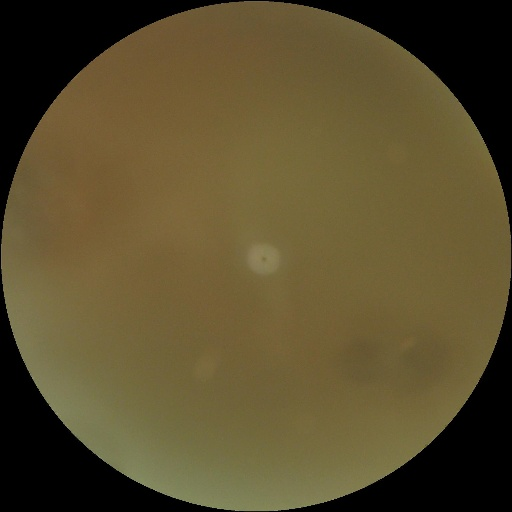

In [11]:
img

In [12]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [13]:
import cv2

def process_row_opencv(row, image_path):
    left_image_path = os.path.join(image_path, row['left_fundus'])
    right_image_path = os.path.join(image_path, row['right_fundus'])

    if os.path.exists(left_image_path) and os.path.exists(right_image_path):
        try:
            # Load images with OpenCV (BGR format)
            left_img = cv2.imread(left_image_path)
            right_img = cv2.imread(right_image_path)

            if left_img is None or right_img is None:
                print(f"Failed to read images for row {row.name}")
                return None

            # Resize images
            left_img = cv2.resize(left_img, (224, 224))
            right_img = cv2.resize(right_img, (224, 224))

            # Convert BGR to RGB
            left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
            right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

            # Normalize
            left_img_array = left_img.astype('float32') / 255.0
            right_img_array = right_img.astype('float32') / 255.0

            # Combine the images (average)
            combined_image = (left_img_array + right_img_array) / 2

            # Collect labels
            labels = [row['normal'], row['glaucoma'], row['cataract'],
                       row['hypertension'], row['myopia']]

            return combined_image, labels
        except Exception as e:
            print(f"Error processing row {row.name}: {e}")
            return None
    else:
        print(f"Images not found for row {row.name}: {left_image_path}, {right_image_path}")
        return None
def load_and_organize_data_parallel_opencv(image_path, metadata_df, num_workers=8):
    # Filter rows where both images exist
    valid_df = metadata_df[
        metadata_df.apply(lambda row: os.path.exists(os.path.join(image_path, row['left_fundus'])) and
                                     os.path.exists(os.path.join(image_path, row['right_fundus'])), axis=1)
    ]

    print(f"Number of valid image pairs: {len(valid_df)}")

    with Pool(num_workers) as pool:
        func = partial(process_row_opencv, image_path=image_path)
        results = pool.map(func, [row for _, row in valid_df.iterrows()])

    # Filter out None results
    results = [res for res in results if res is not None]

    if results:
        image_data, labels = zip(*results)
        return np.array(image_data), np.array(labels)
    else:
        return np.array([]), np.array([])

In [14]:
from multiprocessing import Pool
from functools import partial
import pandas as pd

image_data, labels = load_and_organize_data_parallel_opencv(path, data_df)
print(f"Image data shape: {image_data.shape}")
print(f"Labels shape: {labels.shape}")

Number of valid image pairs: 3034
Image data shape: (3034, 224, 224, 3)
Labels shape: (3034, 5)


In [15]:
image_data.shape

(3034, 224, 224, 3)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.3, random_state=42)

In [17]:


from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, LambdaCallback
from functools import partial

input_shape = (224, 224, 3)

base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output_units = y_train.shape[1]
x = Dense(output_units, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

class EpochAccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: Accuracy = {logs['accuracy']:.4f}, Validation Accuracy = {logs['val_accuracy']:.4f}")

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks =[EpochAccuracyCallback()])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5898 - loss: 0.4000   Epoch 1: Accuracy = 0.7244, Validation Accuracy = 0.8057
17/17 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.5973 - loss: 0.3973 - val_accuracy: 0.8057 - val_loss: 0.3026
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.7857 - loss: 0.3084Epoch 2: Accuracy = 0.7913, Validation Accuracy = 0.8057
17/17 ━━━━━━━━━━━━━━━━━━━━ 69s 878ms/step - accuracy: 0.7860 - loss: 0.3081 - val_accuracy: 0.8057 - val_loss: 0.2809
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7942 - loss: 0.2966Epoch 3: Accuracy = 0.7984, Validation Accuracy = 0.8057
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 886ms/step - accuracy: 0.7944 - loss: 0.2964 - val_accuracy: 0.8057 - val_loss: 0.2790
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.7927 - loss: 0.2905Epoch 4: Accuracy = 0.8003, Validation Accuracy = 0.8057
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s

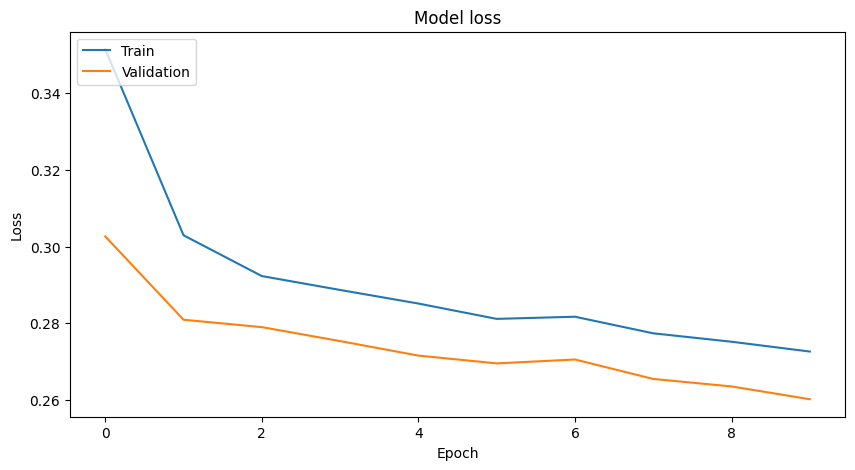

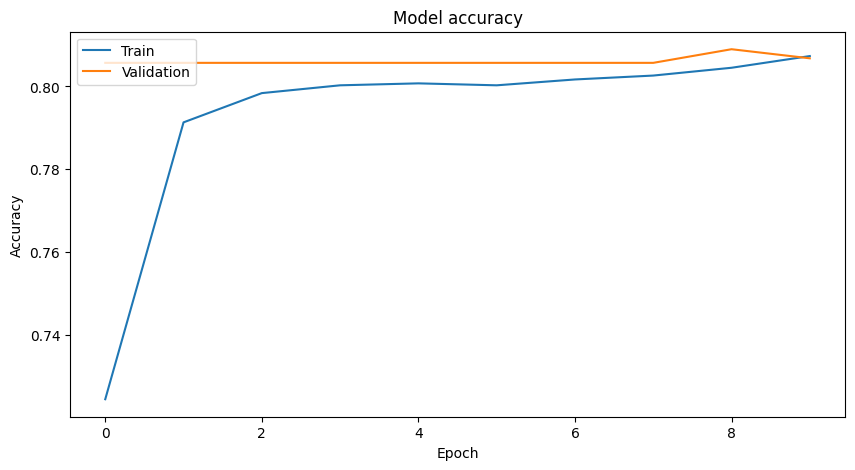

In [18]:


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, LambdaCallback

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output_units = y_train.shape[1]
x = Dense(output_units, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=x)
for layer in base_model.layers:
    layer.trainable = False


class EpochAccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: Accuracy = {logs['accuracy']:.4f}, Validation Accuracy = {logs['val_accuracy']:.4f}")

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=4,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks =[EpochAccuracyCallback()])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/4
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6575 - loss: 0.4107Epoch 1: Accuracy = 0.6750, Validation Accuracy = 0.8057
67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 440ms/step - accuracy: 0.6577 - loss: 0.4104 - val_accuracy: 0.8057 - val_loss: 0.5660
Epoch 2/4
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7067 - loss: 0.3695Epoch 2: Accuracy = 0.7244, Validation Accuracy = 0.8057
67/67 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.7070 - loss: 0.3695 - val_accuracy: 0.8057 - val_loss: 0.5802
Epoch 3/4
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7465 - loss: 0.3438Epoch 3: Accuracy = 0.7301, Validation Accuracy = 0.8057
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7463 - loss: 0.3439 - val_accuracy: 0.8057 - val_loss: 0.5575
Epoch 4/4
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7396 - loss: 0.3632Epoch 4: Accuracy = 0.7362, Validation Accuracy = 0.8057
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/st

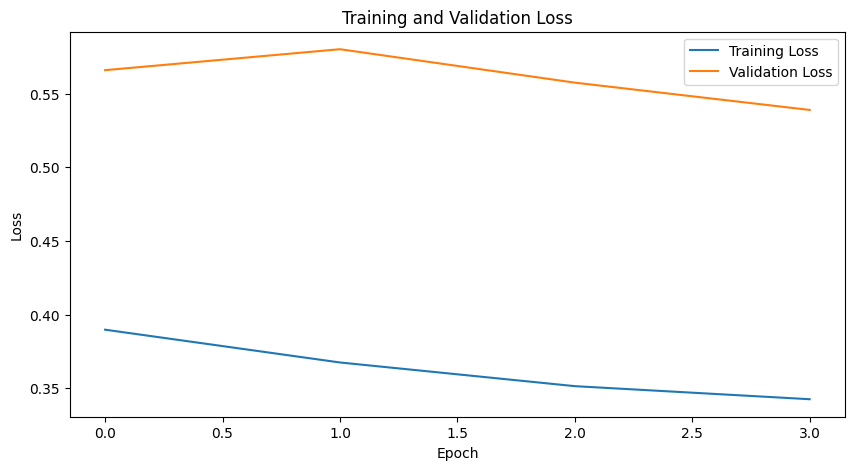

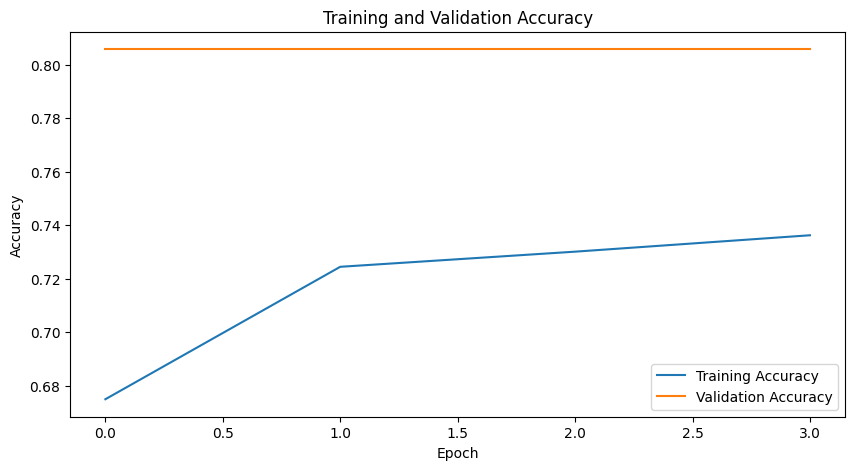

In [20]:


import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step


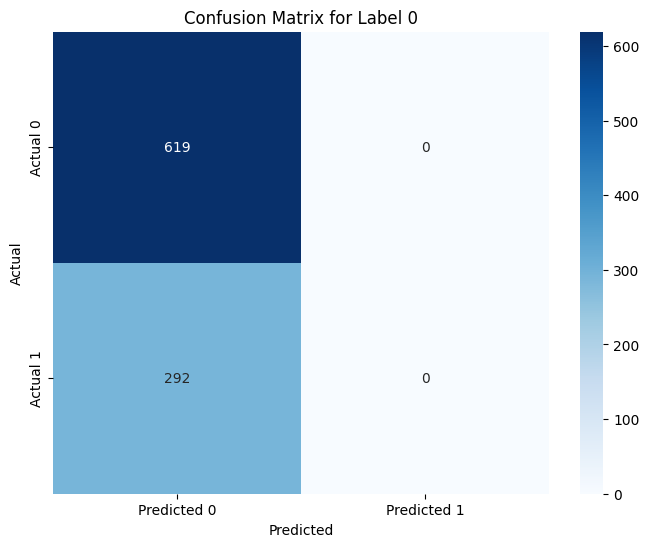

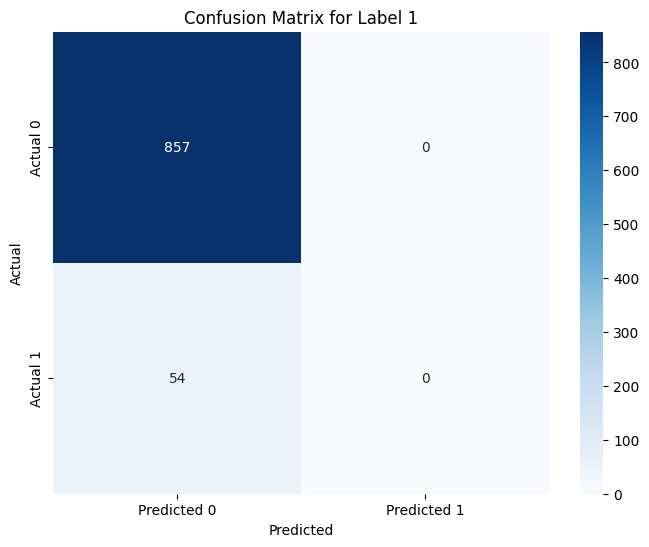

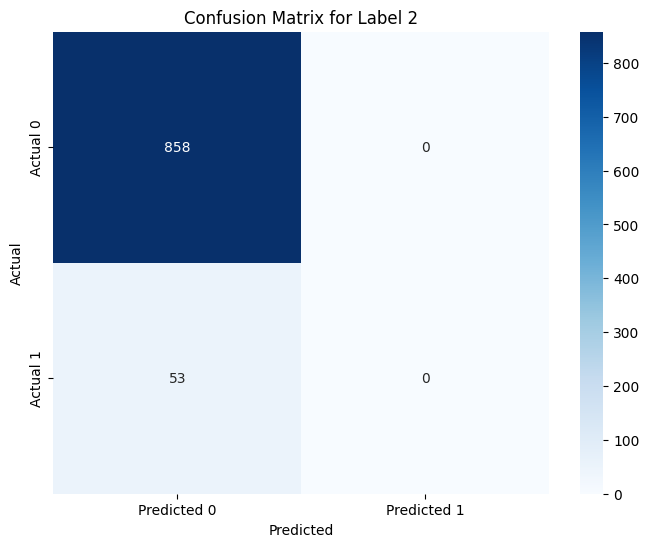

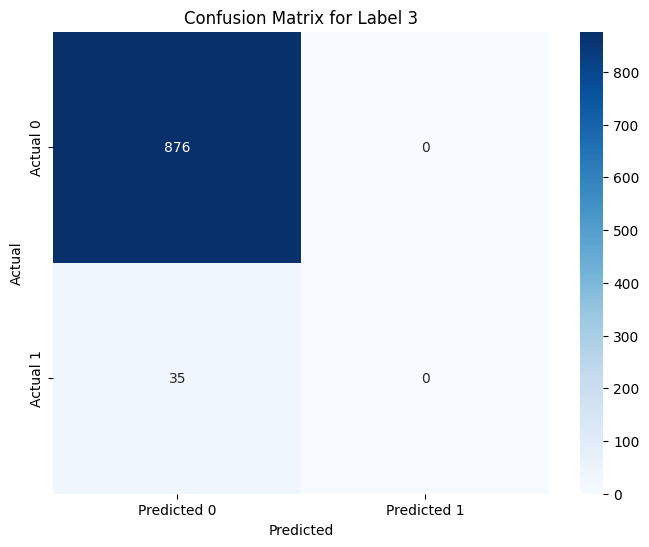

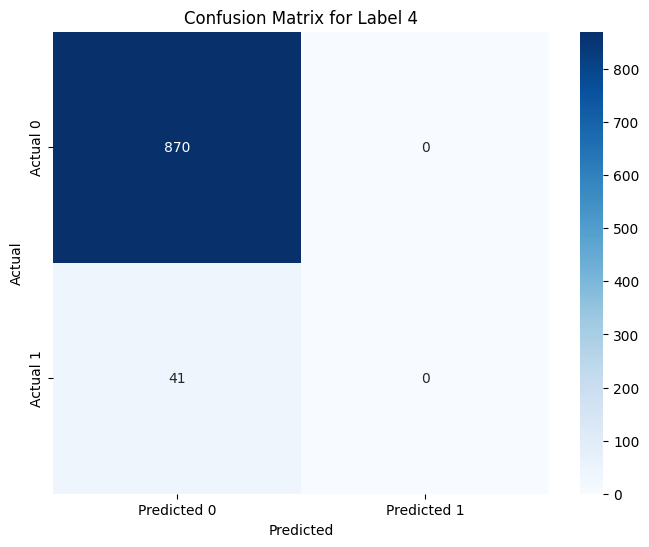

In [21]:


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

for i in range(y_test.shape[1]):
  cm = confusion_matrix(y_test[:,i], y_pred_classes[:,i])
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Predicted 0', 'Predicted 1'],
              yticklabels=['Actual 0', 'Actual 1'])
  plt.title(f'Confusion Matrix for Label {i}')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()